In [1]:
import itertools
import json
from pathlib import Path
import re

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.formula.api as smf

%matplotlib inline
sns.set_style("whitegrid")
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('png')
#set_matplotlib_formats('svg')

%load_ext autoreload
%autoreload 2
import util

In [2]:
# Path to BERT directory, containing model checkpoints
bert_path = Path("~/om2/others/bert").expanduser()
# Base model used as init checkpoint for finetuning
bert_base_model = "uncased_L-12_H-768_A-12"
# Fine-tuning tasks / models
#bert_models = [None, "QQP", "MNLI", "SST", "CoLA", "MRPC", "SNLI", "RTE"]
bert_models = [None, "QQP", "MNLI", "SST"]
checkpoint_steps = list(range(50, 5050, 50))#[1000, 2000, 3000, 4000, 5000]
# Describes the particular fine-tuning regime used
finetune_desc = "finetune-5000"

In [3]:
# For each model, load
# 1. brain decoding results
# 2. checkpoint data: global step, gradient norm information
model_metadata = {}
for model in bert_models:
    print(model)
    if model is None:
        model_dir = bert_path / bert_base_model
    else:
        model_dir = bert_path / ("%s.%s.%s" % (finetune_desc, bert_base_model, model))
        
    model_metadata[model] = util.load_bert_finetune_metadata(model_dir, checkpoint_steps)
        
    # brain decoding results for each checkpoint step
    for checkpoint_step in checkpoint_steps:
        decoding_perf_path = "perf.384sentences.bert.base%s.csv" % \
            ("" if model is None else ".%s-%s-%d" % (finetune_desc, model, checkpoint_step))
        try:
            decoding_perf = pd.read_csv(decoding_perf_path, index_col=[0, 1])
        except: continue
        
        for subj, subj_row in decoding_perf.loc["ridge"].iterrows():
            model_metadata[model]["steps"][checkpoint_step]["decoding_mean_%s" % subj] = subj_row.mean()
            model_metadata[model]["steps"][checkpoint_step]["decoding_std_%s" % subj] = subj_row.std()
            
        model_metadata[model]["steps"][checkpoint_step].update({
            "decoding_mean": decoding_perf.loc["ridge"].mean().mean(),
            "decoding_std": decoding_perf.loc["ridge"].mean(axis=1).std()
        })

None


/opt/conda/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


QQP
MNLI
SST


In [4]:
all_subjects = decoding_perf.index.get_level_values(1)
all_subjects

Index(['P01', 'M02', 'M04', 'M07', 'M08', 'M09', 'M14', 'M15', 'P01', 'M02',
       'M04', 'M07', 'M08', 'M09', 'M14', 'M15'],
      dtype='object', name='subject')

In [5]:
# Flatten model results into a single collection.
model_metadata_flat = []

for model, metadata in model_metadata.items():
    for step, step_data in metadata["steps"].items():
        for subject in all_subjects:
            if "decoding_mean_%s" % subject not in step_data:
                continue
                
            model_metadata_flat.append((model, subject, step,
                                        step_data.get("decoding_mean_%s" % subject, np.nan), step_data.get("decoding_std_%s" % subject, np.nan),
                                        metadata.get("first_train_loss", None), metadata.get("first_train_loss_norm", None),
                                        step_data.get("train_loss", None), step_data.get("train_loss_norm", None),
                                        step_data.get("total_global_norms", None),
                                        step_data.get("eval_loss"), step_data.get("eval_accuracy")))
        
df = pd.DataFrame(model_metadata_flat, columns=("model", "subject", "step", "decoding_mean", "decoding_std",
                                                "first_train_loss", "first_train_loss_norm", "train_loss", "train_loss_norm",
                                                "total_global_norms",
                                                "eval_loss", "eval_accuracy"))

In [6]:
df["train_loss_delta"] = df["train_loss"] - df["first_train_loss"]
df["train_loss_norm_delta"] = df["train_loss_norm"] - df["first_train_loss_norm"]
df.head()

,model,subject,step,decoding_mean,decoding_std,first_train_loss,first_train_loss_norm,train_loss,train_loss_norm,total_global_norms,eval_loss,eval_accuracy,train_loss_delta,train_loss_norm_delta
0,None,P01,50,48.703704,14.904324,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,None,M02,50,61.005291,14.564277,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,None,M04,50,129.359788,30.657785,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,None,M07,50,76.989418,19.413005,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,None,M08,50,118.492063,22.782341,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
df.tail()

,model,subject,step,decoding_mean,decoding_std,first_train_loss,first_train_loss_norm,train_loss,train_loss_norm,total_global_norms,eval_loss,eval_accuracy,train_loss_delta,train_loss_norm_delta
6395,SST,M07,5000,141.976190,23.360313,0.671834,0.335917,0.062572,0.031286,274.153315,0.294372,0.927752,-0.609263,-0.304631
6396,SST,M08,5000,139.828042,27.507716,0.671834,0.335917,0.062572,0.031286,274.153315,0.294372,0.927752,-0.609263,-0.304631
6397,SST,M09,5000,167.166667,24.251820,0.671834,0.335917,0.062572,0.031286,274.153315,0.294372,0.927752,-0.609263,-0.304631
6398,SST,M14,5000,172.423280,34.076121,0.671834,0.335917,0.062572,0.031286,274.153315,0.294372,0.927752,-0.609263,-0.304631
6399,SST,M15,5000,149.388889,23.616621,0.671834,0.335917,0.062572,0.031286,274.153315,0.294372,0.927752,-0.609263,-0.304631


## Model training analysis

Let's verify that each model is not overfitting; if it is overfitting, restrict our analysis to just the region before overfitting begins.

/opt/conda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


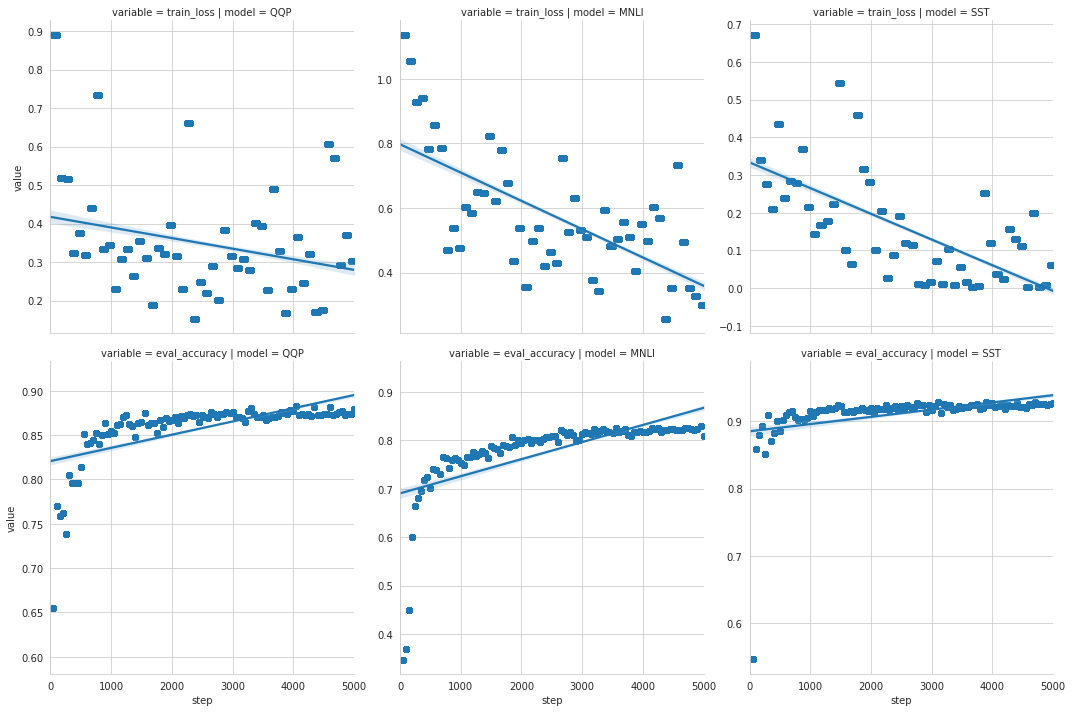

In [8]:
lm = sns.lmplot(data=pd.melt(df, id_vars=["model", "step"], value_vars=["train_loss", "eval_accuracy"]),
                y="value", x="step", col="model", row="variable", sharey=False)
for ax in lm.axes[0]:
    ax.set_xlim((0, 5000))

MRPC and RTE are definitely overfitting — let's exclude some of the later training steps.

In [9]:
df = df.drop(index=df[(df.model == "MRPC") & (df.step > 750)].index)
df = df.drop(index=df[(df.model == "RTE") & (df.step > 1000)].index)
df.describe()

,step,decoding_mean,decoding_std,first_train_loss,first_train_loss_norm,train_loss,train_loss_norm,total_global_norms,eval_loss,eval_accuracy,train_loss_delta,train_loss_norm_delta
count,6400.000000,6400.000000,6400.000000,4800.000000,4800.000000,4800.000000,4800.000000,4800.000000,4800.000000,4800.000000,4800.000000,4800.000000
mean,2525.000000,111.927164,24.682129,0.899710,0.386713,0.361688,0.148849,158.932305,0.377820,0.850098,-0.538022,-0.237863
std,1443.416274,34.173701,7.538055,0.189852,0.045031,0.235504,0.085882,85.846560,0.146862,0.077260,0.164706,0.079595
min,50.000000,45.142857,10.695204,0.671834,0.335917,0.002296,0.001148,1.534149,0.212571,0.347500,-0.879440,-0.368867
25%,1287.500000,77.224868,18.344397,0.671834,0.335917,0.200160,0.095289,86.306168,0.274304,0.815938,-0.655386,-0.293147
50%,2525.000000,118.492063,24.415846,0.890730,0.378855,0.328293,0.153740,166.647659,0.300764,0.870000,-0.570511,-0.252757
75%,3762.500000,142.150132,30.657785,1.136566,0.445365,0.511426,0.189471,228.181494,0.486176,0.913750,-0.466816,-0.194911
max,5000.000000,175.404762,42.058748,1.136566,0.445365,1.136566,0.445365,338.457721,1.101307,0.928750,0.000000,0.000000


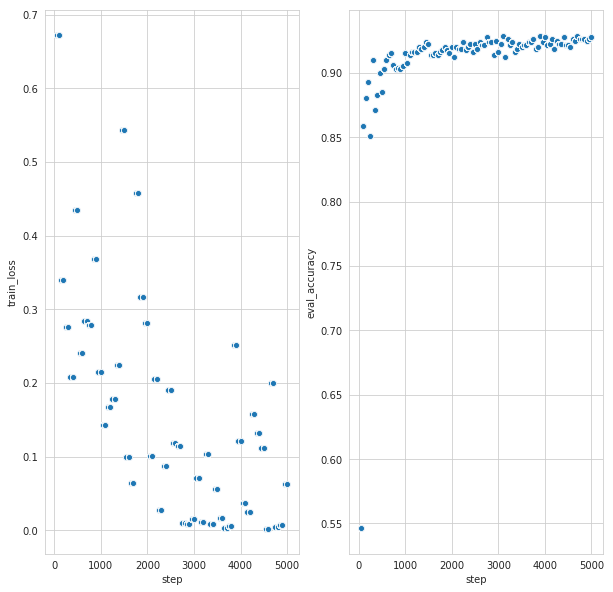

In [10]:
f, axs = plt.subplots(1, 2, figsize=(10, 10))
sns.scatterplot(data=df[df.model == "SST"], x="step", y="train_loss", ax=axs[0])
sns.scatterplot(data=df[df.model == "SST"], x="step", y="eval_accuracy", ax=axs[1])

SST also converges early (around 4000 iters). We'll drop the remaining iterations.

In [11]:
df = df.drop(index=df[(df.model == "SST") & (df.step > 4000)].index)
df.describe()

,step,decoding_mean,decoding_std,first_train_loss,first_train_loss_norm,train_loss,train_loss_norm,total_global_norms,eval_loss,eval_accuracy,train_loss_delta,train_loss_norm_delta
count,6080.000000,6080.000000,6080.000000,4480.000000,4480.000000,4480.000000,4480.000000,4480.000000,4480.000000,4480.000000,4480.000000,4480.000000
mean,2419.736842,110.325251,24.556206,0.915987,0.390341,0.382242,0.156841,152.173174,0.384079,0.844797,-0.533745,-0.233500
std,1402.535221,33.963805,7.671061,0.186129,0.044442,0.229690,0.082838,84.859035,0.150021,0.077287,0.168709,0.080126
min,50.000000,45.142857,10.695204,0.671834,0.335917,0.002981,0.001490,1.534149,0.212571,0.347500,-0.879440,-0.368867
25%,1200.000000,77.224868,17.472718,0.671834,0.335917,0.228926,0.110017,82.247224,0.273671,0.813750,-0.647031,-0.290747
50%,2400.000000,117.349206,24.196830,0.890730,0.378855,0.340259,0.157609,158.878718,0.303079,0.866875,-0.569927,-0.245615
75%,3600.000000,140.886243,30.657785,1.136566,0.445365,0.520959,0.195530,209.015732,0.489248,0.902500,-0.458461,-0.192256
max,5000.000000,175.404762,42.058748,1.136566,0.445365,1.136566,0.445365,338.457721,1.101307,0.928750,0.000000,0.000000


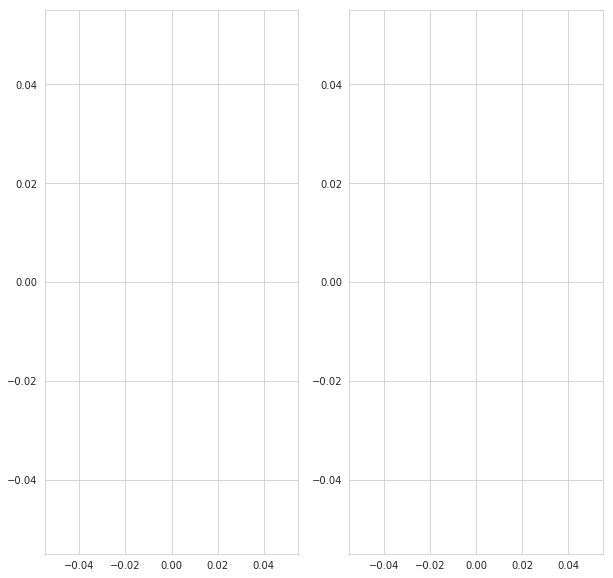

In [12]:
f, axs = plt.subplots(1, 2, figsize=(10, 10))
sns.scatterplot(data=df[df.model == "CoLA"], x="step", y="train_loss", ax=axs[0])
sns.scatterplot(data=df[df.model == "CoLA"], x="step", y="eval_accuracy", ax=axs[1])

CoLA is also overfitting — we reach near-zero training loss by around iter 2000. Drop.

In [13]:
df = df.drop(index=df[(df.model == "CoLA") & (df.step > 2000)].index)
df.describe()

,step,decoding_mean,decoding_std,first_train_loss,first_train_loss_norm,train_loss,train_loss_norm,total_global_norms,eval_loss,eval_accuracy,train_loss_delta,train_loss_norm_delta
count,6080.000000,6080.000000,6080.000000,4480.000000,4480.000000,4480.000000,4480.000000,4480.000000,4480.000000,4480.000000,4480.000000,4480.000000
mean,2419.736842,110.325251,24.556206,0.915987,0.390341,0.382242,0.156841,152.173174,0.384079,0.844797,-0.533745,-0.233500
std,1402.535221,33.963805,7.671061,0.186129,0.044442,0.229690,0.082838,84.859035,0.150021,0.077287,0.168709,0.080126
min,50.000000,45.142857,10.695204,0.671834,0.335917,0.002981,0.001490,1.534149,0.212571,0.347500,-0.879440,-0.368867
25%,1200.000000,77.224868,17.472718,0.671834,0.335917,0.228926,0.110017,82.247224,0.273671,0.813750,-0.647031,-0.290747
50%,2400.000000,117.349206,24.196830,0.890730,0.378855,0.340259,0.157609,158.878718,0.303079,0.866875,-0.569927,-0.245615
75%,3600.000000,140.886243,30.657785,1.136566,0.445365,0.520959,0.195530,209.015732,0.489248,0.902500,-0.458461,-0.192256
max,5000.000000,175.404762,42.058748,1.136566,0.445365,1.136566,0.445365,338.457721,1.101307,0.928750,0.000000,0.000000


## Decoding analyses

Text(0.5,1,'Decoding performance vs. total number of fine-tuning steps')

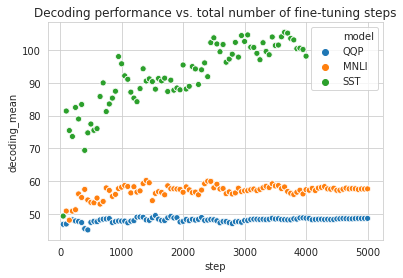

In [14]:
sns.scatterplot(data=df[df.subject == "P01"], y="decoding_mean", x="step", hue="model")
plt.title("Decoding performance vs. total number of fine-tuning steps")

Text(0.5,1,'Decoding performance vs. total number of fine-tuning steps')

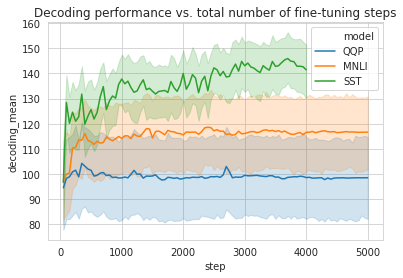

In [15]:
sns.lineplot(data=df.reset_index(), y="decoding_mean", x="step", hue="model")
plt.title("Decoding performance vs. total number of fine-tuning steps")

Text(0.5,1,'Decoding performance vs. total global gradient norm')

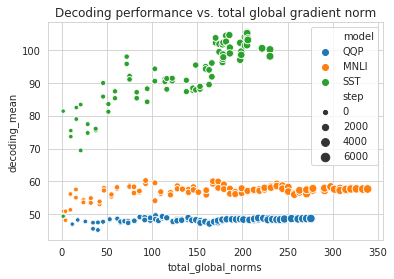

In [16]:
sns.scatterplot(data=df[df.subject == "P01"], y="decoding_mean", x="total_global_norms", hue="model", size="step")
plt.title("Decoding performance vs. total global gradient norm")

Text(0.5,1,'Decoding performance vs. total global gradient norm')

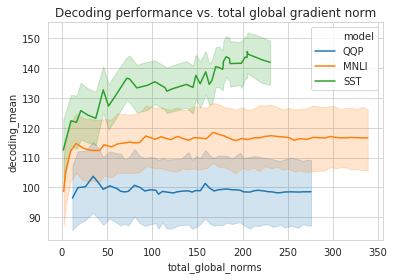

In [17]:
sns.lineplot(data=df, y="decoding_mean", x="total_global_norms", hue="model")
plt.title("Decoding performance vs. total global gradient norm")

/opt/conda/lib/python3.6/site-packages/seaborn/regression.py:279: RuntimeWarning: invalid value encountered in log
  grid = np.c_[np.ones(len(grid)), np.log(grid)]


Text(0.5,0,'Decoding performance vs. total global gradient norm')

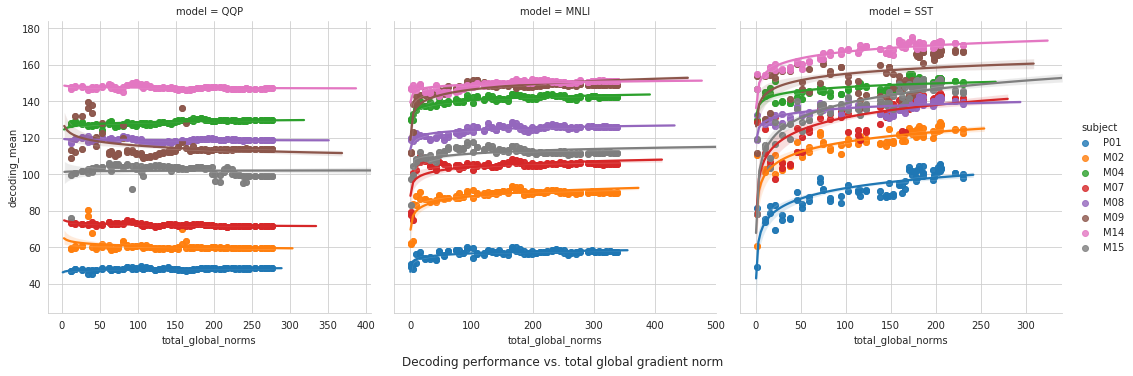

In [18]:
sns.lmplot(data=df, y="decoding_mean", x="total_global_norms", col="model", hue="subject", logx=True, sharex=False)
plt.suptitle("Decoding performance vs. total global gradient norm", y=0)

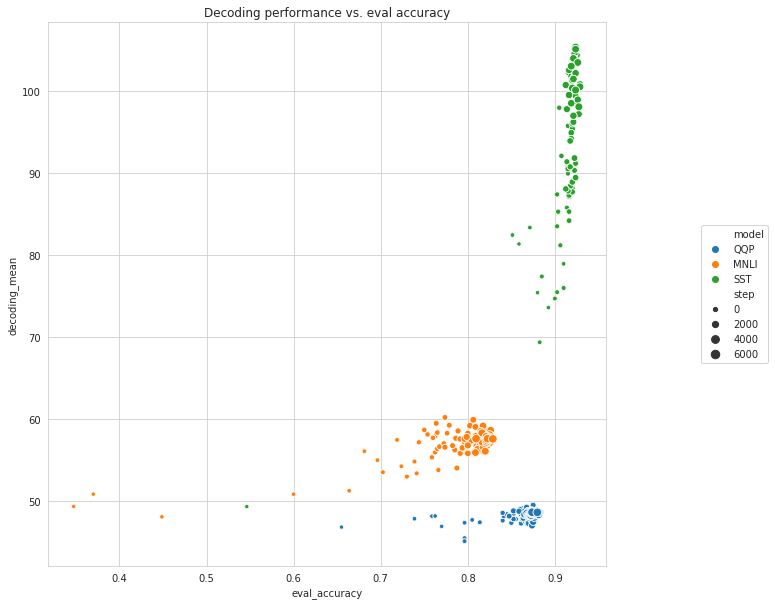

In [19]:
# NB: not directly comparable since the classification tasks have different output spaces
plt.subplots(figsize=(10, 10))
sns.scatterplot(data=df[df.subject == "P01"], y="decoding_mean", x="eval_accuracy", hue="model", size="step")
plt.title("Decoding performance vs. eval accuracy")
plt.legend(loc="right", bbox_to_anchor=(1.3, 0.5))

(30, 170)

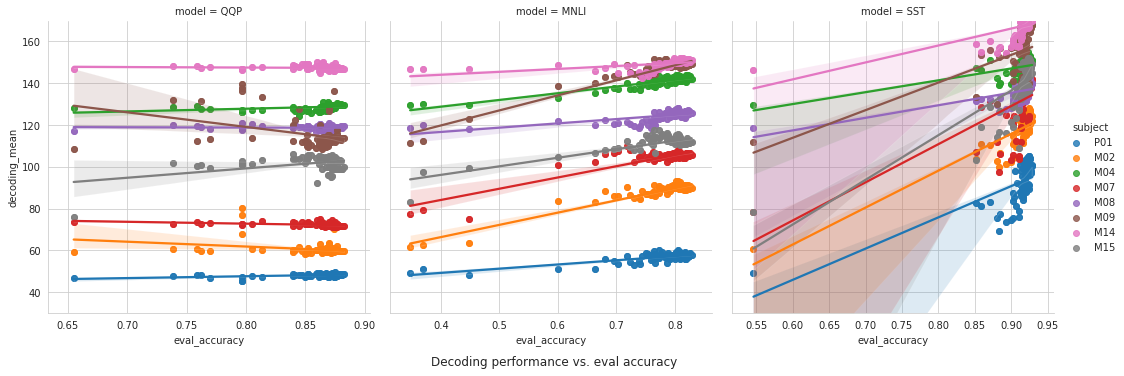

In [20]:
sns.lmplot(data=df, y="decoding_mean", x="eval_accuracy", col="model", hue="subject", sharex=False, truncate=True)
plt.suptitle("Decoding performance vs. eval accuracy", y=0.0)
plt.ylim((30, 170))

## Regression analyses

In [ ]:
%load_ext rpy2.ipython
%R require(brms)

In [ ]:
regression_data = df[df.model.notnull()]
regression_data.to_csv("regression_data.csv")

In [ ]:
%R summary(brm("decoding_mean ~ eval_accuracy + (1 + eval_accuracy | subject)", data=read.csv("regression_data.csv"), iter=10, chains=1))

In [ ]:
%R mylm <- brm("decoding_mean ~ log(eval_accuracy) + (1 + log(eval_accuracy) | subject) + (1 + log(eval_accuracy) | model)", data=read.csv("regression_data.csv"), iter=10, chains=1)

In [ ]:
%R -o ran ran=ranef(mylm)

In [ ]:
%R print(summary(mylm))

## Transfer checks

In [ ]:
transfer_results = {}
for model in bert_models:
    # Get original fine-tune accuracy
    # TODO update "finetune" to `finetune_desc` once we have transfer data for the new limited finetune models
    results_path = bert_path / ("%s.%s.%s" % (finetune_desc, bert_base_model, model)) / "eval_results.txt"
    if results_path.exists():
        with results_path.open("r") as results_f:
            acc, = re.findall(r"^eval_accuracy\s*=\s*([\d.-]+)$", results_f.read(), re.M)
            acc = float(acc)
            transfer_results[model, model] = acc
            
for m1, m2 in itertools.product(bert_models, repeat=2):
    results_path = bert_path / ("eval_transfer-%s" % finetune_desc) / ("results-%s-%s.json" % (m1, m2))
    if not results_path.exists():
        continue
        
    with results_path.open("r") as results_f:
        transfer_results[m1, m2] = json.load(results_f)["results"]["eval_accuracy"]

plt.subplots(figsize=(20, 10))
transfer_results = pd.Series(transfer_results)
transfer_results.index.rename(["m1", "m2"], inplace=True)
transfer_results = transfer_results.sort_index().reset_index()
print(transfer_results)

ax = sns.barplot(data=transfer_results, hue="m2", x="m1", y=0)
i = 0
for bar in sorted(ax.patches, key=lambda bar: bar.get_x()):
    row = transfer_results.iloc[i]
    if not np.isnan(bar.get_height()):
        if row.m1 == row.m2:
            bar.set_hatch("/")
            
        i += 1

In [ ]:
plt.subplots(figsize=(10,10))
sns.heatmap(data=pd.pivot_table(transfer_results, index="m1", columns="m2", values=0), annot=True)